In [4]:
!pip install geohash2

In [5]:
!pip install pytorch_lightning > /dev/null
print("Pytorch_lightning: installed")

Pytorch_lightning: installed


In [6]:
!pip install torch_geometric

In [7]:
import requests
import pandas as pd
import os
import geohash2
import numpy as np

# Dataset preparation:

In [8]:
# @title Download and store the dataset
if False:
  # URL of the dataset text file on GitHub
  text_file_url = 'https://raw.githubusercontent.com/Paco-Danes/DeepPoi/main/dataset_NYC.txt'
  # The directory to store the file in the colab session
  directory_path = '/content/dataset/'
  file_path = os.path.join(directory_path, 'example_dataset.txt')

  # Check if directory exists, if not, create it
  if not os.path.exists(directory_path):
      os.makedirs(directory_path)

  # Download the file
  r = requests.get(text_file_url)

  # Save the content to a file
  with open(file_path, 'w') as f:
      f.write(r.text)
  print("Text file downloaded and saved to:", file_path)

else:
  file_path = "/content/DeepPoi/Data/dataset_NYC.txt"

In [9]:
!git clone https://github.com/Paco-Danes/DeepPoi.git

fatal: destination path 'DeepPoi' already exists and is not an empty directory.


In [10]:
# Column names
columns = [
    'User_ID',
    'Venue_ID',
    'Venue_Category_ID',
    'Venue_Category_Name',
    'Latitude',
    'Longitude',
    'Timezone_Offset',
    'UTC_Time'
]
# Read the TSV file into a DataFrame
df = pd.read_csv(file_path, sep='\t', names = columns, encoding = "latin-1")
# Shape check of the DataFrame
df.shape

(227428, 8)

In [11]:
df.head()

,User_ID,Venue_ID,Venue_Category_ID,Venue_Category_Name,Latitude,Longitude,Timezone_Offset,UTC_Time
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012


In [12]:
# Function to retrieve geohash at different precisions
def get_geohash(row, precision):
    return geohash2.encode(row['Latitude'], row['Longitude'], precision=precision)

# List of precisions, 2 is not present because the whole NYC is in the same cell of precision 2 (every point same G@2 cell, i checked)
precisions = [3, 4, 5, 6]

# Add new columns for each precision
for precision in precisions:
    column_name = f'g{precision}'
    df[column_name] = df.apply(lambda row: get_geohash(row, precision), axis=1)

df['Venue_ID_int'] = pd.factorize(df['Venue_ID'])[0] + 1
df = df.drop('Venue_ID', axis = 1)

In [13]:
df.head()

,User_ID,Venue_Category_ID,Venue_Category_Name,Latitude,Longitude,Timezone_Offset,UTC_Time,g3,g4,g5,g6,Venue_ID_int
0,470,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012,dr5,dr5r,dr5rs,dr5rsh,1
1,979,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012,dr5,dr5r,dr5r5,dr5r50,2
2,69,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012,dr5,dr5r,dr5rw,dr5rws,3
3,395,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012,dr5,dr5r,dr5ru,dr5ru3,4
4,87,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012,dr5,dr5r,dr5ru,dr5ru2,5


In [14]:
print("How many different cells at different precisions does the dataset cover?\n", {x: len(df[x].unique()) for x in ['g3', 'g4', 'g5', 'g6', 'Venue_ID_int']})

How many different cells at different precisions does the dataset cover?
 {'g3': 2, 'g4': 10, 'g5': 128, 'g6': 2483, 'Venue_ID_int': 38333}


In [15]:
grouped_venues = df.groupby('g6')['Venue_ID_int'].unique().to_dict()
grouped_venues['dr5rws'] # venue id = 3 should be there ! Looking at the df.head above.

array([    3, 18047, 30542])

In [ ]:
# @title Build the tree using strings for understanding
class GeoNodeHash:
    def __init__(self, ID):
        self.ID = ID
        self.children = []

def build_tree_with_hashes(df, precisions):
    # Initialize the root nodes with unique g3 strings
    root_nodes = [GeoNodeHash(g3) for g3 in df['g3'].unique()]

    # Initialize a dictionary to store nodes by their name
    node_dict = {g3: node for g3, node in zip(df['g3'].unique(), root_nodes)}

    # Iterate through each precision (g4, g5, g6)
    for precision in precisions[1:]:  # Start from g4
        # Extract unique strings for the current precision
        unique_strings = df[f'g{precision}'].unique()

        # Create nodes for unique strings and connect them to their parent nodes
        for string in unique_strings:
            parent_name = string[:-1]  # Get the parent node's name
            parent_node = node_dict[parent_name]  # Get the parent node
            child_node = GeoNodeHash(string)  # Create the child node
            parent_node.children.append(child_node)  # Connect child to parent
            node_dict[string] = child_node  # Add child node to the dictionary

    # Group venues by g6 string and add them as leaf nodes
    grouped_venues = df.groupby('g6')['Venue_ID_int'].unique().to_dict()
    for g6_value, venues in grouped_venues.items():
        parent_node = node_dict[g6_value]
        for venue in venues:
            child_node = GeoNodeHash(venue)
            parent_node.children.append(child_node)

    return root_nodes

# Construct the tree
GeoTreeRoots = build_tree_with_hashes(df, precisions)

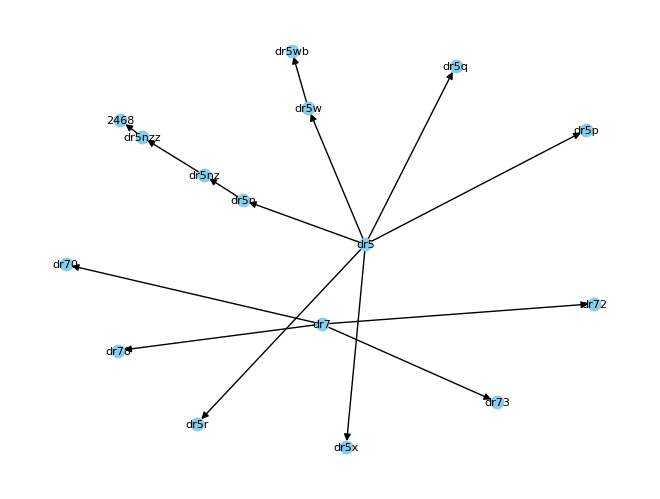

In [ ]:
# @title Plot the tree (pruned for visualization)
import networkx as nx
import matplotlib.pyplot as plt

def add_nodes_edges(G, node):
    if len(node.children) < 7:
      for child in node.children:
          G.add_edge(node.ID, child.ID)
          add_nodes_edges(G, child)

def visualize_tree(root_nodes):
    G = nx.DiGraph()
    for node in root_nodes:
        add_nodes_edges(G, node)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=80, node_color="skyblue", font_size=8, arrows=True)
    plt.show()

# Visualize the tree
visualize_tree(GeoTreeRoots)

In [16]:
# Calculate the minimum and maximum values for latitude and longitude
min_latitude = df['Latitude'].min()
max_latitude = df['Latitude'].max()
min_longitude = df['Longitude'].min()
max_longitude = df['Longitude'].max()

# Min-max normalize latitude and longitude columns
df['Norm_Latitude'] = (df['Latitude'] - min_latitude) / (max_latitude - min_latitude)
df['Norm_Longitude'] = (df['Longitude'] - min_longitude) / (max_longitude - min_longitude)
df['Category_ID'] = pd.factorize(df['Venue_Category_ID'])[0] + 1

for g in ['g3', 'g4', 'g5', 'g6']:
  df[g + "_ID"] = pd.factorize(df[g])[0] + 1

# Drop the original categorical column
df = df.drop(['Venue_Category_ID', 'Latitude', 'Longitude', 'g3', 'g4', 'g5', 'g6'], axis=1)
print(df.shape)

(227428, 12)


In [17]:
df.head()

,User_ID,Venue_Category_Name,Timezone_Offset,UTC_Time,Venue_ID_int,Norm_Latitude,Norm_Longitude,Category_ID,g3_ID,g4_ID,g5_ID,g6_ID
0,470,Arts & Crafts Store,-240,Tue Apr 03 18:00:09 +0000 2012,1,0.386208,0.460596,1,1,1,1,1
1,979,Bridge,-240,Tue Apr 03 18:00:25 +0000 2012,2,0.127885,0.390219,2,1,1,2,2
2,69,Home (private),-240,Tue Apr 03 18:02:24 +0000 2012,3,0.377868,0.662835,3,1,1,3,3
3,395,Medical Center,-240,Tue Apr 03 18:02:41 +0000 2012,4,0.444161,0.494546,4,1,1,4,4
4,87,Food Truck,-240,Tue Apr 03 18:03:00 +0000 2012,5,0.432595,0.482464,5,1,1,4,5


In [ ]:
# @title Build tree using df structure and IDs
from collections import deque
class GeoNode:
    def __init__(self, ID):
        self.ID = ID
        self.children = []
        self.probability = None

    def assign_probabilities(self, probability_arrays, current_level = 0):
        '''Visiting each node in a Depth-First style and assign its predicted probability (skipping the NYC root)'''
        probabilities = probability_arrays[current_level]
        for child in self.children:
            if child.ID <= len(probabilities):
                child.probability = probabilities[child.ID]
            if child.children:
                child.assign_probabilities(probability_arrays, current_level + 1)

    def BFS_joint_prob(self, return_top5 = False):
        if return_top5:
            leaves = []
        else:
            min_leaf = None
            min_log_prob = np.inf
        queue = deque([(self, 0)])  # Using a queue for BFS traversal with joint probability

        while queue:
            node, joint_probability = queue.popleft()
            joint_probability -= np.log(node.probability)

            if not node.children:  # Check if it's a leaf node
                if return_top5:
                    leaves.append((node.ID, joint_probability))
                else:
                    if joint_probability < min_log_prob:
                        min_leaf = node.ID
                        min_log_prob = joint_probability
            else:
                for child in node.children:
                    queue.append((child, joint_probability))
        if return_top5:
            leaves.sort(key=lambda x: x[1])
            return leaves[:5]
        else:
            return min_leaf, min_log_prob

    def beam_search_joint_prob(self, beam_width=1, return_top5 = False):
        # Initialize beam with root node and log_join probability 1
        beam = [(self, 0)]
        if return_top5:
            leaves = []
        else:
            min_leaf = None
            min_log_prob = np.inf

        while beam:
            # Sort beam by joint probability in descending order
            beam.sort(key=lambda x: x[1])

            # Prune beam to keep only top beam_width nodes
            beam = beam[:beam_width]

            # Initialize next beam
            next_beam = []

            # Explore children of nodes in the current beam
            for node, joint_probability in beam:
                if node.probability is not None:
                    joint_probability -= np.log(node.probability) # Summing negative-log probability. At the end, who has the lower sum has the highest joint probability.

                # Check if it's a leaf node and update max probability if needed
                if not node.children:
                    if return_top5:
                        leaves.append((node.ID, joint_probability))
                    else:
                        if joint_probability < min_log_prob:
                            min_leaf = node.ID
                            min_log_prob = joint_probability

                # Add children to the next beam
                for child in node.children:
                    next_beam.append((child, joint_probability))

            # Update beam for next iteration
            beam = next_beam
        if return_top5:
            leaves.sort(key=lambda x: x[1])
            return leaves[:5]
        else:
            return min_leaf, min_log_prob

    def DFS_joint_prob(self, current_probability=1):
        # If the node has a probability, update the current probability
        current_probability *= self.probability
        # If it's a leaf node, return the leaf and its joint probability
        if not self.children:
            return self, current_probability

        max_leaf = None
        max_probability = 0

        # Recursive DFS traversal for each child
        for child in self.children:
            leaf, probability = child.DFS_joint_prob(current_probability)
            if probability > max_probability:
                max_leaf = leaf
                max_probability = probability

        return max_leaf, max_probability

def build_tree(df):
    # Initialize the root nodes with unique g3 IDs
    root_nodes = [GeoNode(g3_id) for g3_id in df['g3_ID'].unique()]

    # Initialize a dictionary to store nodes by their ID
    node_dict = {'g3_node_' + str(g3_id): node for g3_id, node in zip(df['g3_ID'].unique(), root_nodes)}

    # Iterate through each precision (g3, g4, g5, g6)
    precisions = ['g3_ID', 'g4_ID', 'g5_ID', 'g6_ID', 'Venue_ID_int']
    for i in range(len(precisions) - 1):
        parent_precision = precisions[i]
        child_precision = precisions[i + 1]

        # Group by parent ID and get children IDs
        grouped_children = df.groupby(parent_precision)[child_precision].unique()

        # Create child nodes and connect them to their parent nodes
        for parent_id, children_ids in grouped_children.items():
            parent_node = node_dict[parent_precision[:3] +'node_' + str(parent_id)]
            for child_id in children_ids:
                child_node = GeoNode(child_id)
                parent_node.children.append(child_node)
                node_dict[child_precision[:3] + 'node_' + str(child_id)] = child_node  # Add child node to the dictionary

    NYC = GeoNode(None)
    NYC.children = root_nodes
    NYC.probability = 1
    return NYC

# Construct the tree
GeoTree = build_tree(df)

In [ ]:
import numpy as np

In [ ]:
GeoTree.assign_probabilities([[0, 0.8, 0.2], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7 ,0.8, 0.9, 0.99], np.random.rand(129), np.random.rand(2484), np.random.rand(38334)])

In [ ]:
GeoTree.beam_search_joint_prob(beam_width=50, return_top5 = True)

In [ ]:
%timeit GeoTree.BFS_joint_prob(return_top5 = True) # Computes log_prob and top-5 ranked set of leaves
%timeit GeoTree.BFS_joint_prob() # Computes log_prob and just top-1 leaf
%timeit GeoTree.DFS_joint_prob() # This does not use neg-log-probability, it's faster but it would overflow with real data.
%timeit GeoTree.beam_search_joint_prob(beam_width=50, return_top5 = True) # computes log_prob and top-5
%timeit GeoTree.beam_search_joint_prob(beam_width=50) # computes log_prob and top-1

159 ms ± 29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
86.7 ms ± 7.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
31.7 ms ± 977 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
761 µs ± 183 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
677 µs ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
flag = sorted(df['User_ID'].unique()) == list(range(1, df['User_ID'].max() + 1))
print('Check that user_id are all the ints between 1 and max ID: ', flag, '\n Print the first IDs: ')
# Make them start from O
if flag:
  df['User_ID'] = df['User_ID'] - 1
sorted(df['User_ID'].unique())[:11]

Check that user_id are all the ints between 1 and max ID:  True 
 Print the first IDs: 


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
df.to_csv('PreparedDataset.csv', index = False)

# Nets

In [ ]:
#Testing and visualizing the preprocesing
df['UTC_Time'] = pd.to_datetime(df['UTC_Time'])
# Sort the dataframe by user_id and UTC_Time
# P.S: it looks like the dataset is already sorted by date, but it's better to be sure.
df_sorted = df.sort_values(by=['User_ID', 'UTC_Time'])
# Group by user_id and aggregate place_id into lists

In [ ]:
# Group by user_id and aggregate place_id and corresponding grid cell IDs into lists
seqs = df_sorted.groupby('User_ID').apply(lambda x: {'Venue_ID_int': x['Venue_ID_int'].tolist(),
                                                                  'g3_ID': x['g3_ID'].tolist(),
                                                                  'g4_ID': x['g4_ID'].tolist(),
                                                                  'g5_ID': x['g5_ID'].tolist(),
                                                                  'g6_ID': x['g6_ID'].tolist()})
seqs

User_ID
0       {'Venue_ID_int': [2024, 2745, 3671, 4008, 4422...
1       {'Venue_ID_int': [1430, 508, 3742, 4408, 5903,...
2       {'Venue_ID_int': [626, 2564, 2702, 1998, 3377,...
3       {'Venue_ID_int': [359, 408, 408, 408, 408, 408...
4       {'Venue_ID_int': [23993, 24001, 24009, 20074, ...
                              ...                        
1078    {'Venue_ID_int': [330, 821, 849, 821, 849, 484...
1079    {'Venue_ID_int': [2329, 2634, 2876, 2329, 4159...
1080    {'Venue_ID_int': [4964, 35695, 4964, 35728, 16...
1081    {'Venue_ID_int': [615, 650, 2851, 1440, 4691, ...
1082    {'Venue_ID_int': [520, 1417, 1426, 1973, 530, ...
Length: 1083, dtype: object

In [ ]:
print(type(seqs), type(seqs[0]), type(seqs[0]['g3_ID']))
seqs.shape

<class 'pandas.core.series.Series'> <class 'dict'> <class 'list'>


(1083,)

In [ ]:
df.head()

,User_ID,Venue_Category_Name,Timezone_Offset,UTC_Time,Norm_Latitude,Norm_Longitude,Venue_ID_int,Category_ID,g3_ID,g4_ID,g5_ID,g6_ID
0,469,Arts & Crafts Store,-240,2012-04-03 18:00:09+00:00,0.386208,0.460596,1,1,1,1,1,1
1,978,Bridge,-240,2012-04-03 18:00:25+00:00,0.127885,0.390219,2,2,1,1,2,2
2,68,Home (private),-240,2012-04-03 18:02:24+00:00,0.377868,0.662835,3,3,1,1,3,3
3,394,Medical Center,-240,2012-04-03 18:02:41+00:00,0.444161,0.494546,4,4,1,1,4,4
4,86,Food Truck,-240,2012-04-03 18:03:00+00:00,0.432595,0.482464,5,5,1,1,4,5


In [ ]:
def preprocess_dataset(df):
    # Convert UTC_Time column to datetime
    df['UTC_Time'] = pd.to_datetime(df['UTC_Time'])
    # Sort the dataframe by user_id and UTC_Time
    df_sorted = df.sort_values(by=['User_ID', 'UTC_Time'])
    # Group by user_id and aggregate place_id and grid IDs into lists
    sequences = df_sorted.groupby('User_ID').apply(lambda x: {'Venue_ID_int': x['Venue_ID_int'].tolist(),
                                                              'g3_ID': x['g3_ID'].tolist(),
                                                              'g4_ID': x['g4_ID'].tolist(),
                                                              'g5_ID': x['g5_ID'].tolist(),
                                                              'g6_ID': x['g6_ID'].tolist()})
    user_ids = sequences.index.tolist()
    # Split sequences into training and validation
    train_sequences = {}
    val_sequences = {}

    for user_id, seq_data in sequences.items():
        venue_sequence = seq_data['Venue_ID_int']
        g3_sequence = seq_data['g3_ID']
        g4_sequence = seq_data['g4_ID']
        g5_sequence = seq_data['g5_ID']
        g6_sequence = seq_data['g6_ID']

        split_index = int(0.8 * len(venue_sequence))  # 80-20 split

        train_sequences[user_id] = {'Venue_ID_int': venue_sequence[:split_index],
                                     'g3_ID': g3_sequence[:split_index],
                                     'g4_ID': g4_sequence[:split_index],
                                     'g5_ID': g5_sequence[:split_index],
                                     'g6_ID': g6_sequence[:split_index]}

        val_sequences[user_id] = {'Venue_ID_int': venue_sequence[split_index:],
                                   'g3_ID': g3_sequence[split_index:],
                                   'g4_ID': g4_sequence[split_index:],
                                   'g5_ID': g5_sequence[split_index:],
                                   'g6_ID': g6_sequence[split_index:]}

    return train_sequences, val_sequences

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, sequences_with_geohash):
        self.sequences_with_geohash = sequences_with_geohash

    def __len__(self):
        return len(self.sequences_with_geohash) # = number of users

    def __getitem__(self, idx):
        seq_dict = self.sequences_with_geohash[idx] # select a specific user
        # Construct input sequences for user_ID = idx
        inputs = ( torch.tensor(seq_dict['Venue_ID_int'][:-1]), torch.tensor(seq_dict['g3_ID'][:-1]),
                   torch.tensor(seq_dict['g4_ID'][:-1]), torch.tensor(seq_dict['g5_ID'][:-1]), torch.tensor(seq_dict['g6_ID'][:-1]) )

        targets = ( torch.tensor(seq_dict['Venue_ID_int'][1:]), torch.tensor(seq_dict['g3_ID'][1:]),
                   torch.tensor(seq_dict['g4_ID'][1:]), torch.tensor(seq_dict['g5_ID'][1:]), torch.tensor(seq_dict['g6_ID'][1:]) )

        user_id = torch.tensor(idx)

        return inputs, targets, user_id # this will be an element in the batch

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

def custom_collate(batch):
    # Unzip the batch into separate lists of inputs, targets, and user IDs
    inputs_batch, targets_batch, user_ids_batch = zip(*batch)

    # Get the maximum length of the venue sequences in the batch
    max_venue_length = max(len(inputs[0]) for inputs in inputs_batch)  # Assuming venue sequences are always at index 0

    # Initialize lists to store padded inputs, targets, and user IDs
    padded_inputs_batch = []
    padded_targets_batch = []
    user_ids_tensor = torch.tensor(user_ids_batch)

    # Pad each sequence type in the batch to match the maximum venue length
    for inputs, targets in zip(inputs_batch, targets_batch):
        padded_inputs = []
        padded_targets = []

        padding = max_venue_length - len(inputs[0])

        for i in range(len(inputs)):
            # Pad the sequences to match the maximum venue length
            padded_input = torch.nn.functional.pad(inputs[i], (0, padding))
            padded_target = torch.nn.functional.pad(targets[i], (0, padding))
            padded_inputs.append(padded_input)
            padded_targets.append(padded_target)

        padded_inputs_batch.append(tuple(padded_inputs))
        padded_targets_batch.append(tuple(padded_targets))

    # Convert the lists of padded inputs and targets into tensors
    padded_inputs_tensor = tuple(map(torch.stack, zip(*padded_inputs_batch)))
    padded_targets_tensor = tuple(map(torch.stack, zip(*padded_targets_batch)))

    return (padded_inputs_tensor, padded_targets_tensor, user_ids_tensor)


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.nn.utils.rnn import pad_sequence

# Define LightningModule
class StackedLSTMClassifier(pl.LightningModule):
    def __init__(self, lengths, embedding_dim, hidden_size_lstm, num_layers_lstm, dropout_prob=0.33):
        super(StackedLSTMClassifier, self).__init__()

        self.embeddingUser = nn.Embedding(lengths['num_of_users'], embedding_dim)
        self.embeddingVenue = nn.Embedding(lengths['num_of_venues'], embedding_dim, padding_idx = 0)
        self.embeddingG3 = nn.Embedding(lengths['num_of_G3'], embedding_dim, padding_idx = 0)
        self.embeddingG4 = nn.Embedding(lengths['num_of_G4'], embedding_dim, padding_idx = 0)
        self.embeddingG5 = nn.Embedding(lengths['num_of_G5'], embedding_dim, padding_idx = 0)
        self.embeddingG6 = nn.Embedding(lengths['num_of_G6'], embedding_dim, padding_idx = 0)

        self.lstm = nn.LSTM(embedding_dim, hidden_size_lstm, num_layers=num_layers_lstm, batch_first=True)

        self.fc_user_venue = nn.Linear(hidden_size_lstm + embedding_dim, lengths['num_of_venues'])
        self.fc_G3 = nn.Linear(hidden_size_lstm + embedding_dim, lengths['num_of_G3'])
        self.fc_G4 = nn.Linear(hidden_size_lstm + embedding_dim, lengths['num_of_G4'])
        self.fc_G5 = nn.Linear(hidden_size_lstm + embedding_dim, lengths['num_of_G5'])
        self.fc_G6 = nn.Linear(hidden_size_lstm + embedding_dim, lengths['num_of_G6'])

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, v, g3, g4, g5, g6, user_id):
        # Input x: (batch, seqlen)
        venue_embeddings = self.embeddingVenue(v)
        G3_emb = self.embeddingG3(g3)
        G4_emb = self.embeddingG4(g4)
        G5_emb = self.embeddingG5(g5)
        G6_emb = self.embeddingG6(g6)
        # Embed = (batch, seqlen, embed)
        # Input user_id: (batch)
        user_embeddings = self.embeddingUser(user_id)
        # Embed user = (batch, embed)
        lstm_out, _ = self.lstm(venue_embeddings)
        # Concatenate user embeddings to LSTM output
        lstm_out_with_user = torch.cat((lstm_out, user_embeddings.unsqueeze(1).repeat(1, lstm_out.size(1), 1)), dim=-1)
        lstm_out_with_G3 = torch.cat((lstm_out, G3_emb), dim = -1)
        lstm_out_with_G4 = torch.cat((lstm_out, G4_emb), dim = -1)
        lstm_out_with_G5 = torch.cat((lstm_out, G5_emb), dim = -1)
        lstm_out_with_G6 = torch.cat((lstm_out, G6_emb), dim = -1)

        # Apply dropout after the linear layer
        out_user = self.dropout(self.fc_user_venue(lstm_out_with_user))
        out_g3 = self.dropout(self.fc_G3(lstm_out_with_G3))
        out_g4 = self.dropout(self.fc_G4(lstm_out_with_G4))
        out_g5 = self.dropout(self.fc_G5(lstm_out_with_G5))
        out_g6 = self.dropout(self.fc_G6(lstm_out_with_G6))

        return (out_g3, out_g4, out_g5, out_g6, out_user)

    def compute_loss(self, outputs, v, g3, g4, g5, g6):
        loss_fn = nn.CrossEntropyLoss(reduction='mean')
        loss_g3 = loss_fn(outputs[0].transpose(1, 2), g3)  # Transpose outputs for correct shape
        loss_g4 = loss_fn(outputs[1].transpose(1, 2), g4)  # Transpose outputs for correct shape
        loss_g5 = loss_fn(outputs[2].transpose(1, 2), g5)  # Transpose outputs for correct shape
        loss_g6 = loss_fn(outputs[3].transpose(1, 2), g6)  # Transpose outputs for correct shape
        loss_POI = loss_fn(outputs[4].transpose(1, 2), v)  # Transpose outputs for correct shape
        loss_multitask = (loss_POI + loss_g3 + loss_g4 + loss_g5 + loss_g6) / 5
        return loss_multitask

    def training_step(self, batch, batch_idx):
        # Access the input sequences, target sequences, and user ID from the batch dictionary
        # Unpack the batch
        inputs_batch, targets_batch, user_id = batch

        # Unpack the sequences for each type
        venues, g3s, g4s, g5s, g6s = inputs_batch
        venue_tars, g3_tars, g4_tars, g5_tars, g6_tars = targets_batch
        # Assuming your model takes inputs and user embeddings

        outputs = self(venues, g3s, g4s, g5s, g6s, user_id)
        # Compute the loss based on the outputs and targets
        loss = self.compute_loss(outputs, venue_tars, g3_tars, g4_tars, g5_tars, g6_tars )

        # Log the training loss
        self.log('train_loss', loss)

        return loss

    def validation_step(self, batch, batch_idx):
        # Access the input sequences, target sequences, and user ID from the batch dictionary
        # Unpack the batch
        inputs_batch, targets_batch, user_id = batch
        # Unpack the sequences for each type
        venues, g3s, g4s, g5s, g6s = inputs_batch
        venue_tars, g3_tars, g4_tars, g5_tars, g6_tars = targets_batch
        # Assuming your model takes inputs and user embeddings
        outputs = self(venues, g3s, g4s, g5s, g6s, user_id)
        # Compute the loss based on the outputs and targets
        loss = self.compute_loss(outputs, venue_tars, g3_tars, g4_tars, g5_tars, g6_tars )
        self.log('val_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
# Instantiate the model
lengths = {'num_of_venues': len(df['Venue_ID_int'].unique()) + 1, # add one for padding token-index 0, recall each venue/g ID starts from 1
           'num_of_G3': len(df['g3_ID'].unique()) + 1,
           'num_of_G4': len(df['g4_ID'].unique()) + 1,
           'num_of_G5': len(df['g5_ID'].unique()) + 1,
           'num_of_G6': len(df['g6_ID'].unique()) + 1,
           'num_of_users': len(df['User_ID'].unique()), # No padding for users since they are not used as sequences but as single-value embedding in the concatenation
           }

hidden_size = 128
embed_dim = 128
num_layers = 2  # Number of LSTM layers

# Separate the sequences into training and validation
train_sequences, val_sequences = preprocess_dataset(df)

model = StackedLSTMClassifier(lengths, embed_dim, hidden_size, num_layers)

# Create separate datasets and dataloaders for training and validation
train_dataset = CustomDataset(train_sequences)
val_dataset = CustomDataset(val_sequences)

# Use custom collate function for handling variable-length sequences
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate, num_workers=2)

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

# Instantiate TensorBoardLogger
tb_logger = TensorBoardLogger("logs", name="lstm_logs")

# Instantiate the Trainer with TensorBoardLogger
trainer = pl.Trainer(max_epochs=20, accelerator="gpu", devices=1, logger=tb_logger)

# Train the model
trainer.fit(model, train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name           | Type      | Params
----------------------------------------------
0  | embeddingUser  | Embedding | 138 K 
1  | embeddingVenue | Embedding | 4.9 M 
2  | embeddingG3    | Embedding | 384   
3  | embeddingG4    | Embedding | 1.4 K 
4  | embeddingG5    | Embedding | 16.5 K
5  | embeddingG6    | Embedding | 317 K 
6  | lstm           | LSTM      | 264 K 
7  | fc_user_venue  | Linear    | 9.9 M 
8  | fc_G3          | Linear    | 771   
9  | fc_G4          | Linear    | 2.8 K 
10 | fc_G5          | Linear    | 33.2 K
11 | f

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
# Set the model to evaluation mode
import numpy as np
model.eval()

correct_task = np.array([0,0,0,0,0])
total_task = np.array([0,0,0,0,0])

with torch.no_grad():
    for batch in val_dataloader:
        inputs_batch, targets_batch, user_id = batch
        # Unpack the sequences for each type
        venues, g3s, g4s, g5s, g6s = inputs_batch
        venue_tars, g3_tars, g4_tars, g5_tars, g6_tars = targets_batch
        t = [g3_tars, g4_tars, g5_tars, g6_tars, venue_tars, ]
        # Assuming your model takes inputs and user embeddings
        outputs = model(venues, g3s, g4s, g5s, g6s, user_id)
        for i in range(5):
          total = 0
          correct = 0
          _, predicted = torch.max(outputs[i], 2)
          # Flatten predictions and targets to compute accuracy
          predicted = predicted.view(-1)  # Shape: (batch_size * sequence_length)
          targets = t[i].view(-1)      # Shape: (batch_size * sequence_length)
          correct += ((predicted == targets) & (targets != 0)).sum().item()
          total = (targets != 0).sum().item()
          correct_task[i] += correct
          total_task[i] += total

print(total_task, correct_task)
accuracy = correct_task / total_task

[44853 44853 44853 44853 44853] [ 4971 38793 35503 20604 10618]


In [ ]:
print('Accuracy on validation set', (100 * accuracy))

Accuracy on validation set [11.08287071 86.48919805 79.1541257  45.93672664 23.67288699]


In [18]:
import itertools
import torch

g5group = df.groupby('g5_ID')['Venue_ID_int'].unique()
spatial_edges = torch.tensor([], dtype=torch.long)

for pois in g5group:
  spatial_edges = torch.cat( (spatial_edges, torch.tensor(list(itertools.permutations(pois, 2)), dtype=torch.long)) )

In [ ]:
e = torch.tensor([])
test = torch.cat((e, torch.tensor(list(itertools.permutations([1,2,3,4], 2)))))

In [19]:
import torch_geometric
from torch_geometric.data import Data
spatial_nodes = torch.cat((torch.tensor([0]), torch.tensor(df['Venue_ID_int'].unique())))
spatial_graph = Data(x = spatial_nodes, edge_index=spatial_edges.t())

In [20]:
spatial_graph.is_undirected()

True

In [30]:
edge_index = spatial_graph.edge_index

# Step 2: Find the neighbors of node with ID 4
node_id = 1
neighbors = edge_index[1, edge_index[0] == node_id].tolist()

print("Neighbors of node 4:", neighbors)

Neighbors of node 4: [25, 32, 39, 57, 69, 78, 104, 109, 122, 127, 129, 137, 139, 140, 149, 163, 175, 182, 184, 199, 203, 208, 213, 214, 215, 218, 232, 234, 242, 243, 250, 252, 294, 296, 297, 298, 299, 302, 303, 310, 311, 314, 325, 329, 345, 353, 369, 370, 390, 407, 415, 421, 431, 434, 458, 465, 467, 481, 484, 488, 506, 507, 519, 528, 529, 555, 560, 565, 569, 574, 583, 585, 588, 589, 591, 595, 597, 600, 601, 608, 614, 620, 621, 626, 631, 642, 644, 647, 668, 670, 672, 674, 675, 687, 699, 704, 706, 715, 721, 724, 725, 735, 751, 752, 772, 780, 781, 782, 784, 785, 788, 790, 791, 800, 831, 838, 839, 840, 848, 851, 864, 868, 869, 882, 883, 891, 893, 901, 908, 910, 911, 912, 916, 920, 929, 938, 951, 958, 959, 960, 961, 973, 983, 992, 999, 1014, 1017, 1048, 1049, 1131, 1140, 1142, 1150, 1158, 1181, 1210, 1241, 1243, 1247, 1282, 1331, 1342, 1351, 1361, 1379, 1383, 1413, 1437, 1467, 1469, 1471, 1502, 1505, 1520, 1525, 1537, 1559, 1569, 1576, 1580, 1598, 1602, 1613, 1632, 1635, 1636, 1650, 1658, 1

In [33]:
df.head()

,User_ID,Venue_Category_Name,Timezone_Offset,UTC_Time,Venue_ID_int,Norm_Latitude,Norm_Longitude,Category_ID,g3_ID,g4_ID,g5_ID,g6_ID
0,470,Arts & Crafts Store,-240,Tue Apr 03 18:00:09 +0000 2012,1,0.386208,0.460596,1,1,1,1,1
1,979,Bridge,-240,Tue Apr 03 18:00:25 +0000 2012,2,0.127885,0.390219,2,1,1,2,2
2,69,Home (private),-240,Tue Apr 03 18:02:24 +0000 2012,3,0.377868,0.662835,3,1,1,3,3
3,395,Medical Center,-240,Tue Apr 03 18:02:41 +0000 2012,4,0.444161,0.494546,4,1,1,4,4
4,87,Food Truck,-240,Tue Apr 03 18:03:00 +0000 2012,5,0.432595,0.482464,5,1,1,4,5


In [21]:
# Function to calculate time slots
def calculate_time_slot(utc_time):
    utc_time = pd.to_datetime(utc_time)
    day = utc_time.dayofweek  # Monday=0, Sunday=6
    hour = utc_time.hour
    slot = (day * 8) + (hour // 3) + 1  # Calculate time slot
    return slot

# Initialize dictionary to store venue visits
venue_visits = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    venue_id = row['Venue_ID_int']
    utc_time = row['UTC_Time']

    time_slot = calculate_time_slot(utc_time)

    # Add the time slot to the set of time slots for the venue
    if venue_id in venue_visits:
        venue_visits[venue_id].add(time_slot)
    else:
        venue_visits[venue_id] = {time_slot}

print(venue_visits)

{1: {32, 33, 7, 39, 15, 47, 48, 55, 21, 23, 26, 31}, 2: {1, 6, 7, 8, 9, 13, 14, 15, 16, 17, 21, 22, 24, 25, 26, 28, 29, 30, 31, 32, 33, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56}, 3: {2, 3, 6, 7, 10, 11, 14, 15, 16, 18, 19, 22, 23, 25, 26, 27, 30, 33, 35, 38, 39, 41, 42, 43, 44, 46, 47, 50, 51, 54}, 4: {6, 15}, 5: {6, 7, 14, 15, 31}, 6: {37, 15, 16, 48, 54, 55}, 7: {32, 37, 5, 38, 13, 14, 15, 21, 22, 55, 29, 31}, 8: {36, 15, 16, 17, 24, 28}, 9: {33, 1, 6, 39, 41, 42, 12, 15, 48, 49, 18, 16, 17, 51, 54, 23, 56, 25}, 10: {15}, 11: {8, 41, 10, 9, 15, 48, 49, 17, 25}, 12: {32, 33, 37, 38, 7, 40, 14, 47, 48, 16, 15, 46, 25, 30, 31}, 13: {29, 21, 38, 15}, 14: {5, 6, 7, 13, 14, 15, 16, 21, 22, 23, 29, 30, 31, 32, 37, 38, 39, 40, 45, 46, 47, 48, 54}, 15: {7, 39, 15, 23, 31}, 16: {37, 6, 38, 44, 45, 14, 15, 22, 23, 28, 29, 30}, 17: {5, 6, 7, 14, 15, 16, 17, 23, 24, 25, 31, 32, 33, 39, 40, 41, 45, 47, 49, 55, 56}, 18: {6, 38, 13, 14, 15, 48, 22, 23, 28, 30, 31}, 19: 

In [22]:
temporal_edges = []
# Iterate over combinations of venue IDs
for ven, other_ven in itertools.combinations(venue_visits.keys(), 2):
    set_one = venue_visits[ven]
    set_two = venue_visits[other_ven]

    # Calculate Jaccard similarity
    jaccard_similarity = len(set_one.intersection(set_two)) / len(set_one.union(set_two))

    # Add edge if similarity is below threshold
    if jaccard_similarity >= 0.9:
        temporal_edges.append([ven, other_ven])

temporal_edges = torch.tensor(temporal_edges, dtype=torch.long)
temp_nodes = torch.cat( (torch.tensor([0]), torch.tensor(list(venue_visits))) )
temporal_graph = Data(x=temp_nodes, edge_index = temporal_edges.t())
print('Done')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [43]:
# Assuming 'data' is your PyTorch Geometric Data object
torch.save(temporal_graph, 'temporal_graph.pt')
# Later, you can load the saved data
loaded_data = torch.load('temporal_graph.pt')